In [1]:
#Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

import numpy as np
import mahotas
import cv2
import os
import h5py
import glob
import warnings

from matplotlib import pyplot

warnings.filterwarnings('ignore')

/home/marcio/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
fixed_size = tuple((100, 100))
train_path = "../testes/cyst_IC/train"
h5_data = '../testes/output/data.h5'
h5_labels = '../testes/output/labels.h5'
bins = 8

In [3]:
# Descritor 1: Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# Descritor 2: Haralick Texture
def fd_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# Descritor 3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

In [4]:
train_labels = os.listdir(train_path)

# classificação
train_labels.sort()
print(train_labels)

['K', 'R', 'S']


In [5]:
# vetores descritores
global_features = []
labels = []

In [6]:
for training_name in train_labels:
    dir = os.path.join(train_path, training_name)
    list = os.listdir(dir)
    number_files = len(list)

    current_label = training_name

    for x in range(1,number_files+1):
        file = dir + "/(" + str(x) + ").png"

        image = cv2.imread(file)
        image = cv2.resize(image, fixed_size)

        fv_hu_moments = fd_hu_moments(image)
        fv_haralick   = fd_haralick(image)
        fv_histogram  = fd_histogram(image)

        global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

        labels.append(current_label)
        global_features.append(global_feature)

    print("Processando pasta: {}".format(current_label))

Processando pasta: K
Processando pasta: R
Processando pasta: S


In [7]:
# codificando descritores
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)

In [8]:
# normalizando a matriz de descritores
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)

In [9]:
# salvando os descritores no formato HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(rescaled_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

In [10]:
# TREINANDO COM OS DESCRITORES
num_trees = 100
test_size = 0.50
seed = 9
test_path = "../testes/cyst_IC/test"
scoring = "accuracy"

train_labels = os.listdir(train_path)

train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

In [11]:
# Criando os modelos de machine learning
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

In [12]:
results = []
names = []

# importando os descritores
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

In [13]:
# separando os dados em teste e validação
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

LR: 0.891634 (0.025795)
LDA: 0.891611 (0.026146)
KNN: 0.986967 (0.007789)
CART: 0.943051 (0.016365)
RF: 0.987683 (0.011275)
NB: 0.676930 (0.029928)
SVM: 0.678457 (0.029585)


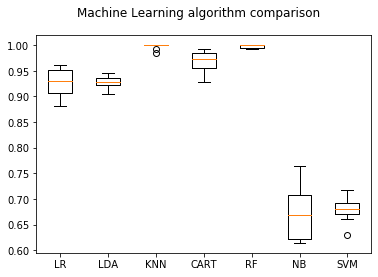

In [14]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# comparando os algoritmos
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [15]:
import matplotlib.pyplot as plt

In [16]:
# Explorando o melhor algoritmo: RF
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# trainamento
clf.fit(trainDataGlobal, trainLabelsGlobal)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

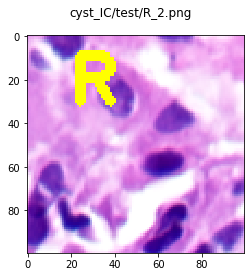

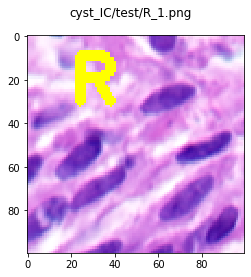

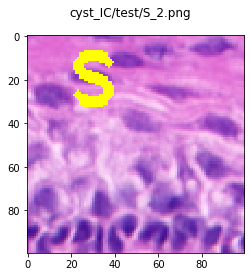

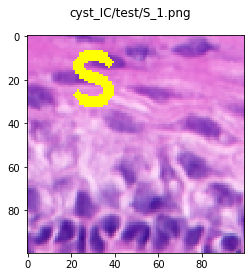

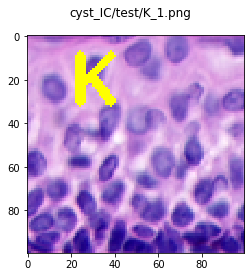

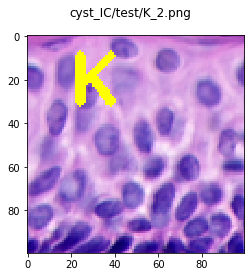

In [17]:
# alguns testes
for file in glob.glob(test_path + "/*.png"):
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)

    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])

    scaler = MinMaxScaler(feature_range=(0, 1))
    rescaled_feature = global_feature
    prediction = clf.predict(rescaled_feature.reshape(1,-1))[0]

    cv2.putText(image, train_labels[prediction], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    plt.suptitle(file)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()